In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as data
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from datetime import datetime 

C:\Users\vedu2\anaconda32\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [9]:
portfolio = 1e5 #Portfolio total worth of 1 lakh
tscost = 0.005 #Per trade transaction cost of 0.5%, so if two stocks of 30 each are bought, (1+0.005)*2*30 is charged in total
nstocks = 0

#stock_list = ['HDFC.NS','ITC.NS','RELIANCE.NS','ONGC.NS','COALINDIA.NS','HDFCBANK.NS','ICICIBANK.NS','ONGC.NS','KOTAKBANK.NS'] #Stock list, to add a stock simply
stock_list = ['BHEL.NS','ITC.NS','LUPIN.NS','RELIANCE.NS','IBVENTURES.NS']                                                                          #add the ticker according to Yahoo! Finance
for stock in stock_list:
    nstocks+=1   

In [10]:
stocks = []#Function to read Data
def readData(ticker, n):
    stocks.append(data.DataReader(ticker, 'yahoo',start='1/1/2015')) #Taking backtesting period as roughly 5 years

In [11]:
def RSI(df):
    "function to calculate RSI ,assume period to be 14 buyt could be anything"
    rsi_period = 14
    change = df['Close'].diff(1)
    gain  = change.mask(change<0,0)#basically whichever have loss itll put gain as zero
    loss = change.mask(change>0,0)#basically whichever have gain,it will put loss as zero
    avg_gain = gain.ewm(com = rsi_period - 1,min_periods = rsi_period).mean()
    avg_loss = loss.ewm(com = rsi_period -1 ,min_periods = rsi_period).mean()
    RS = abs(avg_gain/avg_loss)
    RSI = 100 - 1/(1+RS) 
    df['RSI'] = pd.Series(RSI)
    

In [12]:
def BBands(df1):
    window = 25
    no_of_std = 2
    rolling_mean1 = df1['Adj Close'].rolling(window).mean()
    rolling_std1 = df1['Adj Close'].rolling(window).std()
    
    df1['Bollinger High'] = rolling_mean1 + (rolling_std1 * no_of_std)
    df1['Bollinger Mid'] = rolling_mean1
    df1['Bollinger Low'] = rolling_mean1 - (rolling_std1 * no_of_std)

In [13]:

def StochasticOscillator(df1):
    MaxHigh = df1['High'].rolling(14).max()
    MinLow =df1['Low'].rolling(14).min()
    k=((df1['Close']-MinLow)/(MaxHigh-MinLow))#calculating the stochastic oscillator
    b = (k*100)#Storing values of stochastic oscillator conerting value to range in between 100 and 0.
    df1['%k']=b
    df1['%d']= df1['%k'].rolling(3).mean()

In [14]:
#df['Position'].iloc[row-1] = 0 means downtrend yesterday
#df['Position'].iloc[row-1] = 1 means uptrend yesterday
#df['Position'].iloc[row] = 1 means go long today
#df['Position'].iloc[row] = -1 means go short today
#df['Position'].iloc[row] = 0 means hold
def BBandStrategy(df1):
    df1['Position'] = 0
    for row in range(1,len(df1)):
        if df1['Position'].iloc[row-1]==0 :

            if (df1['Adj Close'].iloc[row] < df1['Bollinger High'].iloc[row]) and df1['RSI'].iloc[row]>70 and (df1['Adj Close'].iloc[row-1] > df1['Bollinger High'].iloc[row]) and(df1['%k'].iloc[row]<df1['%d'].iloc[row]):
                df1['Position'].iloc[row] = -1
            elif (df1['Adj Close'].iloc[row] > df1['Bollinger Low'].iloc[row])and df1['RSI'].iloc[row]<30 and (df1['Adj Close'].iloc[row-1] < df1['Bollinger Low'].iloc[row-1])and (df1['%k'].iloc[row]>df1['%d'].iloc[row]):
                df1['Position'].iloc[row] = 1
            else :
                df1['Position'].iloc[row] = 0
            
        elif df1['Position'].iloc[row-1]== 1 :
            if df1['Adj Close'].iloc[row] > df1['Bollinger High'] and df1['RSI'].iloc[row-1]>70 and  df1['%k'].iloc[row]<df1['%d'].iloc[row]:
                df1['Position'].iloc[row] = -1
            else:
                df1['Position'].iloc[row] = 1

        else:
            if (df1['Adj Close'].iloc[row]<df1['Bollinger Low'].iloc[row]) or (df1['Adj Close'].iloc[row]>df1['Bollinger High'].iloc[row]):
                df1['Position'].iloc[row] = 0
            elif df1['Adj Close'].iloc[row]>df1['Bollinger High'].iloc[row] and df['RSI'].iloc[row] > 70 and df1['%k'].iloc[row]<df1['%d'].iloc[row]:
                df1['Position'].iloc[row] = -1
            elif df1['Adj Close'].iloc[row] < df1['Bollinger Low'].iloc[row] and df1['RSI'].iloc[row]<30 and df1['%k'].iloc[row]>df1['%d'].iloc[row]:
                df1['Position'].iloc[row] = 1
                

In [15]:
for i in range(nstocks):
    for ticker in stock_list:
        readData(ticker,i)
        RSI(stocks[i])
        BBands(stocks[i])
        StochasticOscillator(stocks[i])
        BBandStrategy(stocks[i])

C:\Users\vedu2\anaconda32\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
s = (len(stocks[0]),nstocks) #setting the dimensions of the weights vector depending on the available data points
weights = np.zeros(s) 


for row in range(len(stocks[0])):
    i = 0
    sumwts = 0
    for i in range(nstocks):
        sumwts+=np.abs(stocks[i]['Position'].iloc[row]) #checking how many positions were taken on that day
    for i in range(nstocks):
        if sumwts>0:
            #weights assigned as:
            #weights = (portfolio*position)/(no.of positions * adj close on that day * (1+transac cost))
            weights[row][i]=(portfolio*stocks[i]['Position'].iloc[row])/((sumwts*stocks[i]['Adj Close'].iloc[row])*(1+tscost))
        else:
            weights[row][i]=0
i = 0


for i in range(nstocks):
    stocks[i]['Market Return'] = (stocks[i]['Adj Close'] - stocks[i]['Adj Close'].shift(1)) #Absolute market return

    
#Calculating portfolio return
stocks[0]['Strategy Return']=0
i = 0
for i in range(nstocks):
    stocks[0]['Strategy Return']+=stocks[i]['Market Return'] * weights[:,i] #multiplying market return of each
                                                                            #ticker with its weight


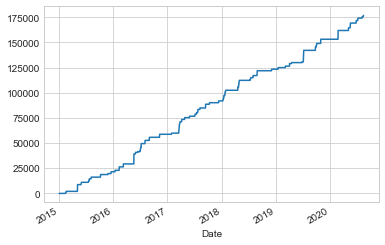

In [17]:
stocks[0]['Strategy Return'].cumsum().plot() #Plotting strategy return